In [1]:
from __future__ import annotations

import json
import re
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Repo paths ---
REPO_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
OUTPUTS_DIR = REPO_ROOT / "outputs"

assert OUTPUTS_DIR.exists(), f"Could not find outputs/ at: {OUTPUTS_DIR}"
print("Repo root:", REPO_ROOT)
print("Outputs dir:", OUTPUTS_DIR)

Repo root: /Users/thomasfish/Desktop/Quant_Portfolio/Quant_Research
Outputs dir: /Users/thomasfish/Desktop/Quant_Portfolio/Quant_Research/outputs


In [2]:
RUN_PATTERN = re.compile(r"^(?P<stem>.+)\.(timeseries|trades|metrics)\.(csv|json)$")

def discover_runs(outputs_dir: Path) -> pd.DataFrame:
    """
    Build a run index from files in outputs/.
    Expects files like:
      <run_id>.timeseries.csv
      <run_id>.trades.csv
      <run_id>.metrics.json
    """
    files = list(outputs_dir.glob("*.*.*"))
    rows = []
    for f in files:
        m = RUN_PATTERN.match(f.name)
        if not m:
            continue
        run_id = m.group("stem")
        rows.append((run_id, f))
    if not rows:
        return pd.DataFrame(columns=["run_id", "timeseries", "trades", "metrics"])

    df = pd.DataFrame(rows, columns=["run_id", "path"])
    # pivot into columns by suffix
    def kind_of(p: Path) -> str:
        if p.name.endswith(".timeseries.csv"): return "timeseries"
        if p.name.endswith(".trades.csv"): return "trades"
        if p.name.endswith(".metrics.json"): return "metrics"
        return "other"

    df["kind"] = df["path"].apply(kind_of)
    piv = df.pivot_table(index="run_id", columns="kind", values="path", aggfunc="first").reset_index()
    for col in ["timeseries", "trades", "metrics"]:
        if col not in piv.columns:
            piv[col] = pd.NA
    # Sort: newest-ish first if timestamp suffix exists
    piv = piv.sort_values("run_id", ascending=False).reset_index(drop=True)
    return piv

def load_timeseries(path: Path) -> pd.DataFrame:
    ts = pd.read_csv(path)

    # Handle different date column names (your file uses "Date")
    if "date" in ts.columns:
        date_col = "date"
    elif "Date" in ts.columns:
        date_col = "Date"
    else:
        raise ValueError(
            f"No date column found in {path.name}. "
            f"Columns are: {list(ts.columns)}"
        )

    ts[date_col] = pd.to_datetime(ts[date_col])
    ts = ts.sort_values(date_col).set_index(date_col)
    ts.index.name = "date"  # normalize index name
    return ts

def load_metrics(path: Path) -> Dict:
    with open(path, "r") as f:
        return json.load(f)

runs_index = discover_runs(OUTPUTS_DIR)
runs_index.head(10)

kind,run_id,metrics,timeseries,trades
0,strat3_peakdd_10pct_fixed_50__20251220_151218,/Users/thomasfish/Desktop/Quant_Portfolio/Quan...,/Users/thomasfish/Desktop/Quant_Portfolio/Quan...,/Users/thomasfish/Desktop/Quant_Portfolio/Quan...
1,strat2_21d_5pct_prop__20251220_151450,/Users/thomasfish/Desktop/Quant_Portfolio/Quan...,/Users/thomasfish/Desktop/Quant_Portfolio/Quan...,/Users/thomasfish/Desktop/Quant_Portfolio/Quan...
2,strat2_21d_5pct_fixed_50__20251220_151327,/Users/thomasfish/Desktop/Quant_Portfolio/Quan...,/Users/thomasfish/Desktop/Quant_Portfolio/Quan...,/Users/thomasfish/Desktop/Quant_Portfolio/Quan...
3,strat1_benchmark__20251220_150830,/Users/thomasfish/Desktop/Quant_Portfolio/Quan...,/Users/thomasfish/Desktop/Quant_Portfolio/Quan...,/Users/thomasfish/Desktop/Quant_Portfolio/Quan...


In [3]:
# Pick run_ids from runs_index["run_id"]
# Example:
# SELECTED_RUNS = [
#   "strat1_benchmark__20251220_150830",
#   "strat2_21d_5pct_fixed_50__20251220_151045",
# ]

SELECTED_RUNS = [
    "strat1_benchmark__20251220_150830",
]
SELECTED_RUNS

['strat1_benchmark__20251220_150830']

In [4]:
selected = runs_index[runs_index["run_id"].isin(SELECTED_RUNS)].copy()
missing = [r for r in SELECTED_RUNS if r not in set(selected["run_id"])]
if missing:
    raise ValueError(f"Missing run_ids in outputs/: {missing}")

run_ts: Dict[str, pd.DataFrame] = {}
run_metrics: Dict[str, Dict] = {}

for _, row in selected.iterrows():
    run_id = row["run_id"]
    ts_path = Path(row["timeseries"])
    metrics_path = Path(row["metrics"])

    run_ts[run_id] = load_timeseries(ts_path)
    run_metrics[run_id] = load_metrics(metrics_path)

list(run_ts.keys()), list(run_metrics.keys())

(['strat1_benchmark__20251220_150830'], ['strat1_benchmark__20251220_150830'])

In [5]:
PREFERRED_METRIC_KEYS = [
    ("start", "start"),
    ("end", "end"),
    ("total_contributions", "total_contrib"),
    ("terminal_value", "terminal_value"),
    ("simple_return_pct", "simple_return_%"),
    ("irr_annualized_estimate", "irr_ann"),
    ("twr_annualized", "twr_ann"),
    ("cagr", "cagr"),
    ("max_drawdown_pct", "max_dd_%"),
    ("num_trades", "num_trades"),
]

def metrics_to_row(m: Dict) -> Dict:
    out = {}
    for src, dst in PREFERRED_METRIC_KEYS:
        out[dst] = m.get(src, np.nan)
    return out

summary_df = pd.DataFrame(
    [{"run_id": rid, **metrics_to_row(run_metrics[rid])} for rid in SELECTED_RUNS]
).set_index("run_id")

# Pretty formatting for display
summary_df

,start,end,total_contrib,terminal_value,simple_return_%,irr_ann,twr_ann,cagr,max_dd_%,num_trades
run_id,,,,,,,,,,
strat1_benchmark__20251220_150830,2005-02-25,2025-12-19,25100.0,95740.656822,281.43688,NaN,0.415379,NaN,-36.637258,502


In [6]:
def common_date_index(dfs: Dict[str, pd.DataFrame]) -> pd.DatetimeIndex:
    idx = None
    for df in dfs.values():
        idx = df.index if idx is None else idx.intersection(df.index)
    return idx

common_idx = common_date_index(run_ts)
print("Common date range:", common_idx.min().date(), "->", common_idx.max().date(), "n=", len(common_idx))

Common date range: 2005-02-25 -> 2025-12-19 n= 5238


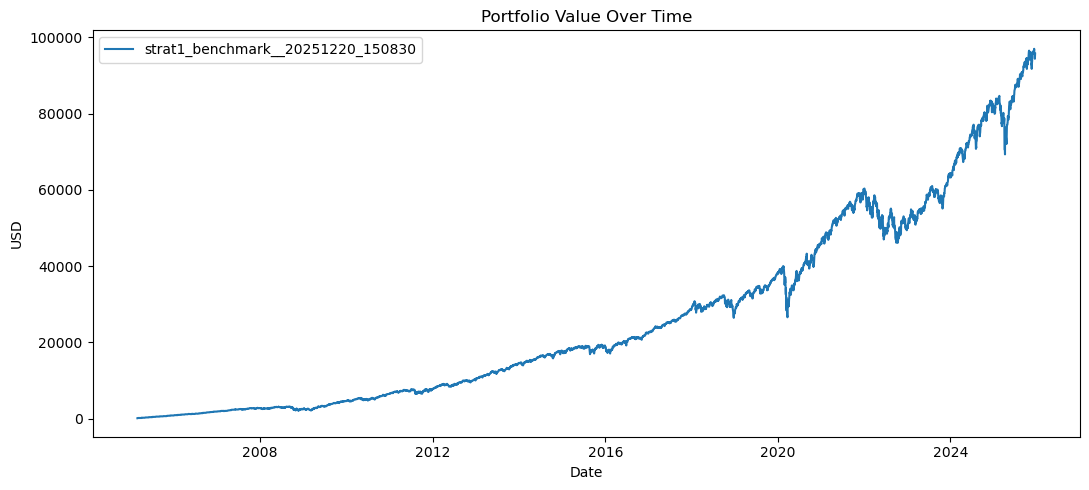

In [7]:
VALUE_COL = "portfolio_value"

plt.figure(figsize=(11, 5))
for rid in SELECTED_RUNS:
    ts = run_ts[rid].reindex(common_idx)
    if VALUE_COL not in ts.columns:
        raise KeyError(f"{rid}: missing column '{VALUE_COL}'. Columns: {list(ts.columns)[:20]}")
    plt.plot(ts.index, ts[VALUE_COL].values, label=rid)

plt.title("Portfolio Value Over Time")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.tight_layout()
plt.show()

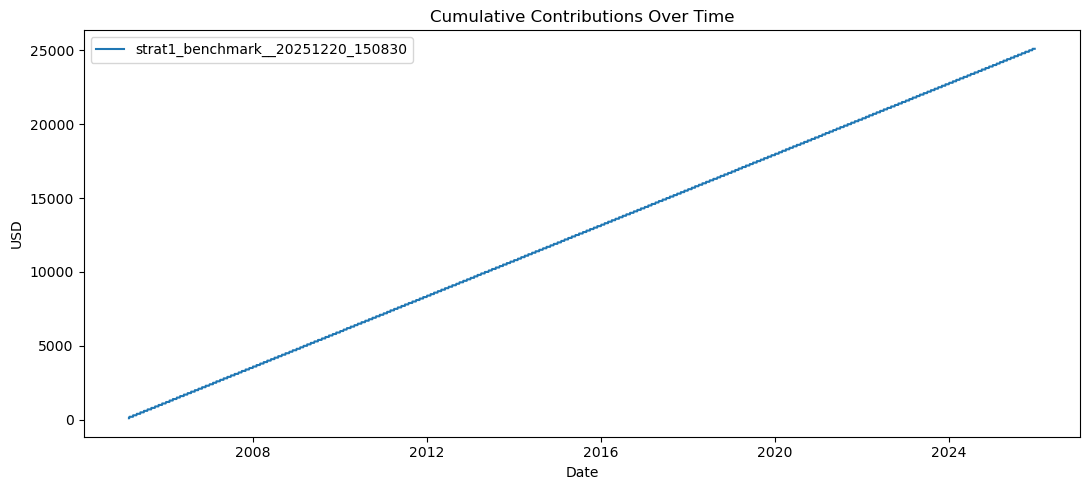

In [8]:
CUMCONTRIB_COL = "cumulative_contributions"

plt.figure(figsize=(11, 5))
for rid in SELECTED_RUNS:
    ts = run_ts[rid].reindex(common_idx)
    if CUMCONTRIB_COL not in ts.columns:
        # fallback: derive from 'contribution' if present
        if "contribution" in ts.columns:
            cum = ts["contribution"].fillna(0).cumsum().abs()
        else:
            raise KeyError(f"{rid}: missing '{CUMCONTRIB_COL}' and 'contribution'. Columns: {list(ts.columns)[:20]}")
    else:
        cum = ts[CUMCONTRIB_COL]
    plt.plot(ts.index, cum.values, label=rid)

plt.title("Cumulative Contributions Over Time")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.tight_layout()
plt.show()

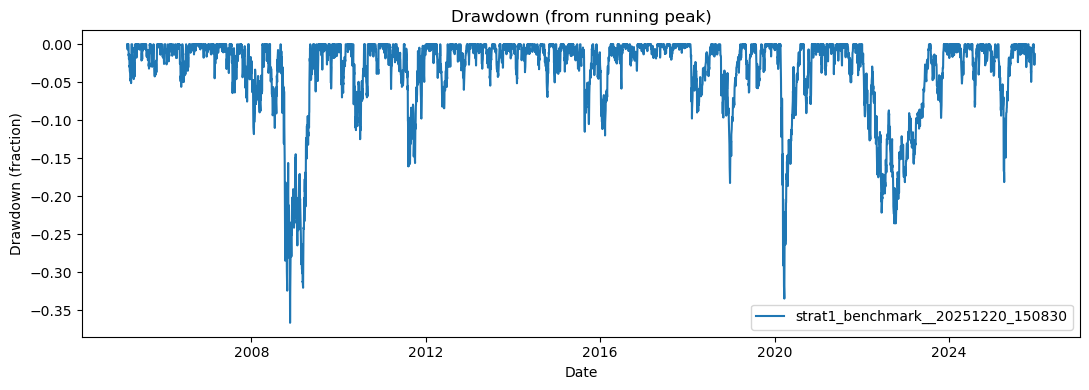

In [9]:
DD_COL_CANDIDATES = ["drawdown", "portfolio_drawdown"]

plt.figure(figsize=(11, 4))
for rid in SELECTED_RUNS:
    ts = run_ts[rid].reindex(common_idx)
    dd_col = next((c for c in DD_COL_CANDIDATES if c in ts.columns), None)
    if dd_col is not None:
        dd = ts[dd_col]
    else:
        v = ts[VALUE_COL].astype(float)
        dd = v / v.cummax() - 1.0
    plt.plot(ts.index, dd.values, label=rid)

plt.title("Drawdown (from running peak)")
plt.xlabel("Date")
plt.ylabel("Drawdown (fraction)")
plt.legend()
plt.tight_layout()
plt.show()

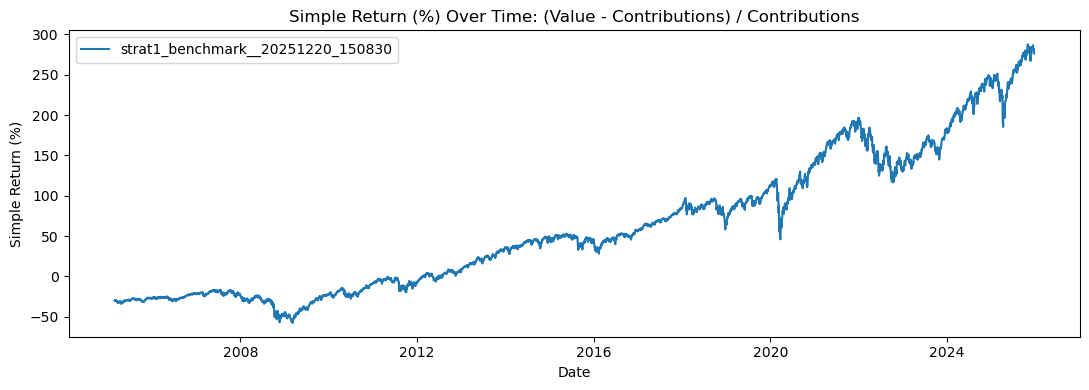

In [10]:
def simple_return_pct(ts: pd.DataFrame) -> pd.Series:
    v = ts[VALUE_COL].astype(float)
    if CUMCONTRIB_COL in ts.columns:
        c = ts[CUMCONTRIB_COL].astype(float)
    elif "contribution" in ts.columns:
        c = ts["contribution"].fillna(0).cumsum().abs()
    else:
        raise KeyError("Need cumulative_contributions or contribution column.")
    c_safe = c.replace(0, np.nan)
    return (v - c) / c_safe * 100.0

plt.figure(figsize=(11, 4))
for rid in SELECTED_RUNS:
    ts = run_ts[rid].reindex(common_idx)
    sr = simple_return_pct(ts)
    plt.plot(sr.index, sr.values, label=rid)

plt.title("Simple Return (%) Over Time: (Value - Contributions) / Contributions")
plt.xlabel("Date")
plt.ylabel("Simple Return (%)")
plt.legend()
plt.tight_layout()
plt.show()

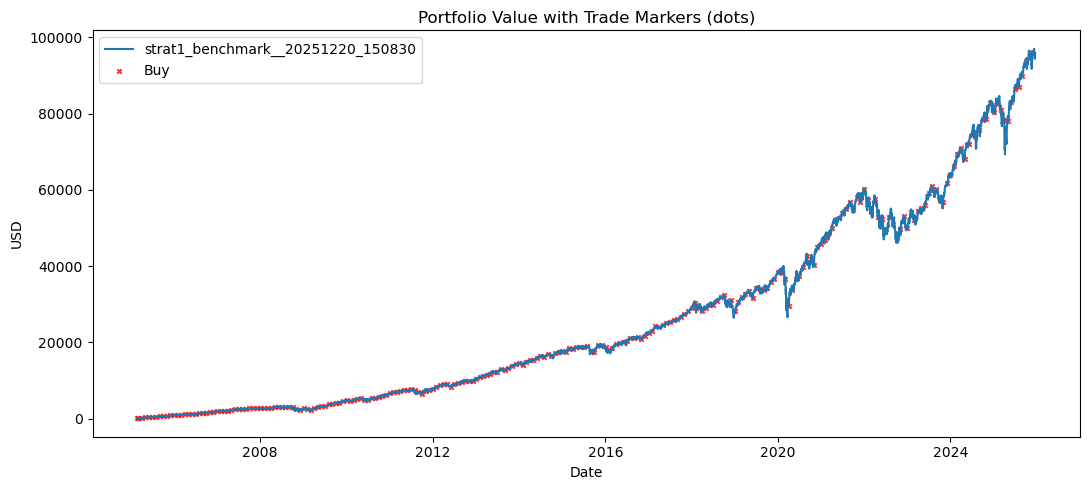

In [11]:
def load_trades(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, parse_dates=["date"])
    return df.sort_values("date")

plt.figure(figsize=(11, 5))
for _, row in selected.iterrows():
    rid = row["run_id"]
    ts = run_ts[rid].reindex(common_idx)
    plt.plot(ts.index, ts[VALUE_COL].values, label=rid)

    tr_path = row.get("trades", None)
    if pd.notna(tr_path):
        trades = load_trades(Path(tr_path))
        # plot buy dates as dots
        buy_dates = trades["date"].unique()
        y = ts.loc[ts.index.intersection(pd.to_datetime(buy_dates)), VALUE_COL]
        plt.scatter(
        y.index,
        y.values,
        marker="x",
        c="red",
        s=10,
        alpha=0.8,
        label="Buy"
        )

plt.title("Portfolio Value with Trade Markers (dots)")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend()
plt.tight_layout()
plt.show()